In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import cuda, float32
import math
import cupy as cp

# Check if CUDA is available
try:
    cuda_device = cuda.get_current_device()
    print(f"CUDA Device: {cuda_device.name.decode('utf-8')}")
    print(f"Compute Capability: {cuda_device.compute_capability}")
    free_mem, total_mem = cuda.current_context().get_memory_info()
    print(f"Memory: {total_mem / 1e9:.2f} GB")
    has_gpu = True
except Exception as e:
    print(f"No CUDA device detected: {e}")
    has_gpu = False

CUDA Device: NVIDIA A100-PCIE-40GB
Compute Capability: (8, 0)
Memory: 42.35 GB


In [4]:
def generate_matrices(n, dtype=np.float32):
    """Generate two random square matrices of size n x n"""
    A = np.random.random((n, n)).astype(dtype)
    B = np.random.random((n, n)).astype(dtype)
    return A, B

def validate_result(C_reference, C_test, rtol=1e-5):
    """Check if the calculated result matches the reference"""
    return np.allclose(C_reference, C_test, rtol=rtol)

def benchmark(func, sizes, repeat=3):
    """Benchmark a function for different matrix sizes"""
    times = []
    for n in sizes:
        A, B = generate_matrices(n)
        
        # Warm-up run
        _ = func(A, B)
        
        # Timed runs
        elapsed = []
        for _ in range(repeat):
            start = time.time()
            _ = func(A, B)
            # Make sure CUDA operations are completed
            if has_gpu:
                cuda.synchronize()
            elapsed.append(time.time() - start)
        
        times.append(min(elapsed))  # Use minimum time for best performance
        print(f"Size {n}x{n}: {min(elapsed):.5f} seconds")
    
    return times

In [5]:
#Naive CPU based Matrix Multiplication

def naive_cpu_matmul(A, B):
    #Basic CPU matrix multiplication with triple nested loops
    n = A.shape[0]  # Assuming square matrices
    C = np.zeros((n, n), dtype=A.dtype)
    
    # Triple nested loop - the classic O(n³) algorithm
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]
                
    return C

In [6]:
def numpy_matmul(A, B):
    #NumPy's optimized matrix multiplication
    return np.matmul(A, B)

# Test and verify our naive implementation
n_test = 100  # Small enough for a quick check
A_test, B_test = generate_matrices(n_test)

# Calculate reference result using NumPy
C_numpy = numpy_matmul(A_test, B_test)

# Calculate result using our naive implementation
C_naive = naive_cpu_matmul(A_test, B_test)

# Verify the result
print(f"Naive CPU implementation correct: {validate_result(C_numpy, C_naive)}")

Naive CPU implementation correct: True


In [7]:
#GPU-accelerated Matrix Multiplication using Numba
@cuda.jit
def cuda_matmul_kernel(A, B, C):
    #CUDA kernel for matrix multiplication.
    #Each thread computes one element of C.

    # Get thread indices
    i, j = cuda.grid(2)
    
    # Check if thread is within valid range
    if i < C.shape[0] and j < C.shape[1]:
        # Compute C[i,j] = sum(A[i,:] * B[:,j])
        tmp = 0.0
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

def numba_cuda_matmul(A, B):
    #Perform matrix multiplication on GPU using Numba CUDA

    # Make sure we're working with the right data type
    A = np.asarray(A, dtype=np.float32)
    B = np.asarray(B, dtype=np.float32)
    
    # Initialize result matrix
    C = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)
    
    # Copy matrices to device
    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)
    C_device = cuda.to_device(C)
    
    # Set up grid dimensions
    # You might need to adjust these for your specific GPU
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(A.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(B.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    
    # Launch kernel
    cuda_matmul_kernel[blocks_per_grid, threads_per_block](A_device, B_device, C_device)
    
    # Retrieve result from device
    C = C_device.copy_to_host()
    
    return C

In [8]:
if has_gpu:
    # Test GPU implementation on small matrices
    C_numba = numba_cuda_matmul(A_test, B_test)
    print(f"Numba CUDA implementation correct: {validate_result(C_numpy, C_numba)}")
else:
    print("Skipping CUDA test (no GPU available)")

/home/sshubhankar/install/python/ENTER/envs/numba2024/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Numba CUDA implementation correct: True


In [9]:
#cuBLAS based Optimized Matrix Multiplication
def cublas_matmul(A, B):
    #Matrix multiplication using cuBLAS (via CuPy)

    # Convert to CuPy arrays
    A_gpu = cp.asarray(A)
    B_gpu = cp.asarray(B)
    
    # Compute using cuBLAS
    C_gpu = cp.matmul(A_gpu, B_gpu)
    
    # Copy result back to CPU
    C = cp.asnumpy(C_gpu)
    
    return C

In [10]:
if has_gpu:
    # Test cuBLAS implementation
    C_cublas = cublas_matmul(A_test, B_test)
    print(f"cuBLAS implementation correct: {validate_result(C_numpy, C_cublas)}")
else:
    print("Skipping cuBLAS test (no GPU available)")

cuBLAS implementation correct: True


In [11]:
@cuda.jit
def tiled_matmul_kernel(A, B, C): 
    #CUDA kernel for matrix multiplication using shared memory tiles
    
    # Define shared memory arrays for the tiles
    TILE_SIZE = 16  # Tile size (must match threads_per_block)
    shared_A = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    shared_B = cuda.shared.array(shape=(TILE_SIZE, TILE_SIZE), dtype=float32)
    
    # Thread and block indices
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Row and column in the result matrix C
    row = by * TILE_SIZE + ty
    col = bx * TILE_SIZE + tx
    
    # Accumulate result for C[row, col]
    tmp = 0.0
    
    # Loop over tiles of A and B
    for t in range((A.shape[1] + TILE_SIZE - 1) // TILE_SIZE):
        # Load A tile into shared memory
        if row < A.shape[0] and t * TILE_SIZE + tx < A.shape[1]:
            shared_A[ty, tx] = A[row, t * TILE_SIZE + tx]
        else:
            shared_A[ty, tx] = 0.0
            
        # Load B tile into shared memory
        if t * TILE_SIZE + ty < B.shape[0] and col < B.shape[1]:
            shared_B[ty, tx] = B[t * TILE_SIZE + ty, col]
        else:
            shared_B[ty, tx] = 0.0
            
        # Wait until all threads load their tiles
        cuda.syncthreads()
        
        # Compute dot product for the current tile
        for k in range(TILE_SIZE):
            tmp += shared_A[ty, k] * shared_B[k, tx]
            
        # Ensure all computations are done before loading next tile
        cuda.syncthreads()
    
    # Write final result to C
    if row < C.shape[0] and col < C.shape[1]:
        C[row, col] = tmp

def tiled_shared_matmul(A, B):
    #Perform matrix multiplication on GPU using shared memory tiles

    # Make sure we're working with the right data type
    A = np.asarray(A, dtype=np.float32)
    B = np.asarray(B, dtype=np.float32)
    
    # Initialize result matrix
    C = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)
    
    # Copy matrices to device
    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)
    C_device = cuda.to_device(C)
    
    # Set up grid dimensions
    TILE_SIZE = 16
    threads_per_block = (TILE_SIZE, TILE_SIZE)
    blocks_per_grid_x = math.ceil(B.shape[1] / TILE_SIZE)
    blocks_per_grid_y = math.ceil(A.shape[0] / TILE_SIZE)
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    
    # Launch kernel
    tiled_matmul_kernel[blocks_per_grid, threads_per_block](A_device, B_device, C_device)
    
    # Retrieve result from device
    C = C_device.copy_to_host()
    
    return C

In [12]:
if has_gpu:
    # Test tiled shared memory implementation
    C_tiled = tiled_shared_matmul(A_test, B_test)
    print(f"Tiled shared memory implementation correct: {validate_result(C_numpy, C_tiled)}")
else:
    print("Skipping tiled shared memory test (no GPU available)")

Tiled shared memory implementation correct: True


/home/sshubhankar/install/python/ENTER/envs/numba2024/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [13]:
def mpi_matmul_example(): 
    #Example code showing how multi-GPU matrix multiplication would be implemented.
    
    #This code would need to be saved as a separate file and run with:
    #$ mpirun -np <num_gpus> python mpi_matmul.py

    try:
        from mpi4py import MPI
    except ImportError:
        print("mpi4py not installed. Please install it for multi-GPU support.")
        return
    
    # Initialize MPI
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()  # Current process ID
    size = comm.Get_size()  # Total number of processes
    
    # Select GPU based on rank
    if has_gpu:
        device_id = rank % cuda.get_num_devices()
        cp.cuda.Device(device_id).use()
        print(f"Process {rank} using GPU {device_id}")
    
    # Matrix size
    n = 1000
    
    # Process 0 generates the matrices
    if rank == 0:
        print(f"Generating {n}x{n} matrices")
        A, B = generate_matrices(n)
        
        # Compute reference solution for validation
        C_ref = numpy_matmul(A, B)
    else:
        A = None
        B = None
        C_ref = None
    
    # Broadcast matrix B to all processes (all processes need the entire B)
    B = comm.bcast(B, root=0)
    
    # Scatter rows of A among processes
    rows_per_proc = n // size
    A_local = np.zeros((rows_per_proc, n), dtype=np.float32)
    comm.Scatter([A, MPI.FLOAT], [A_local, MPI.FLOAT], root=0)
    
    # Each process computes its part using CuPy/cuBLAS
    if has_gpu:
        A_local_gpu = cp.asarray(A_local)
        B_gpu = cp.asarray(B)
        C_local_gpu = cp.matmul(A_local_gpu, B_gpu)
        C_local = cp.asnumpy(C_local_gpu)
    else:
        C_local = np.matmul(A_local, B)
    
    # Gather results
    C = None
    if rank == 0:
        C = np.zeros((n, n), dtype=np.float32)
    
    comm.Gather([C_local, MPI.FLOAT], [C, MPI.FLOAT], root=0)
    
    # Validate result on process 0
    if rank == 0:
        print(f"Multi-GPU result correct: {validate_result(C_ref, C)}")
        
print("Multi-GPU implementation would need to be run separately with mpirun.")
print("Above is a sample implementation sketch.")

Multi-GPU implementation would need to be run separately with mpirun.
Above is a sample implementation sketch.



Benchmarking naive CPU implementation:
Size 128x128: 1.11902 seconds
Size 256x256: 8.86997 seconds
Size 512x512: 72.26226 seconds

Benchmarking NumPy implementation:
Size 128x128: 0.00005 seconds
Size 256x256: 0.00015 seconds
Size 512x512: 0.00407 seconds
Size 1024x1024: 0.01207 seconds

Benchmarking Numba CUDA implementation:
Size 128x128: 0.00079 seconds
Size 256x256: 0.00093 seconds
Size 512x512: 0.00222 seconds
Size 1024x1024: 0.00958 seconds

Benchmarking cuBLAS implementation:
Size 128x128: 0.00024 seconds
Size 256x256: 0.00029 seconds
Size 512x512: 0.00045 seconds
Size 1024x1024: 0.00141 seconds

Benchmarking tiled shared memory implementation:
Size 128x128: 0.00065 seconds
Size 256x256: 0.00072 seconds
Size 512x512: 0.00126 seconds
Size 1024x1024: 0.00346 seconds


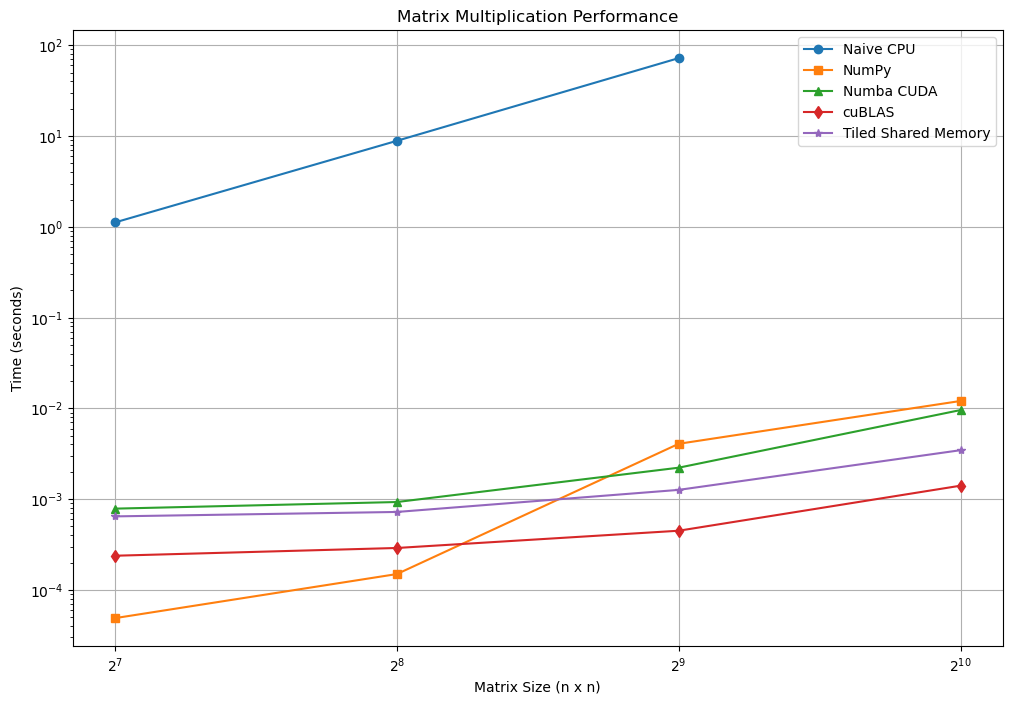


Speedup relative to NumPy:
Size 128x128:
  Naive CPU: 0.00x slower
  Numba CUDA: 0.06x faster
  cuBLAS: 0.21x faster
  Tiled Shared Memory: 0.08x faster
Size 256x256:
  Naive CPU: 0.00x slower
  Numba CUDA: 0.16x faster
  cuBLAS: 0.52x faster
  Tiled Shared Memory: 0.21x faster
Size 512x512:
  Naive CPU: 0.00x slower
  Numba CUDA: 1.83x faster
  cuBLAS: 9.07x faster
  Tiled Shared Memory: 3.22x faster
  Numba CUDA: 1.26x faster
  cuBLAS: 8.58x faster
  Tiled Shared Memory: 3.49x faster


In [16]:
if has_gpu:
    # Define sizes to benchmark (increase these for more meaningful comparisons)
    sizes = [128, 256, 512, 1024]
    
    # Skip naive CPU for larger sizes as it's too slow
    cpu_sizes = [128, 256, 512]
    
    print("\nBenchmarking naive CPU implementation:")
    cpu_times = benchmark(naive_cpu_matmul, cpu_sizes)
    
    print("\nBenchmarking NumPy implementation:")
    numpy_times = benchmark(numpy_matmul, sizes)
    
    print("\nBenchmarking Numba CUDA implementation:")
    numba_times = benchmark(numba_cuda_matmul, sizes)
    
    print("\nBenchmarking cuBLAS implementation:")
    cublas_times = benchmark(cublas_matmul, sizes)
    
    print("\nBenchmarking tiled shared memory implementation:")
    tiled_times = benchmark(tiled_shared_matmul, sizes)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(cpu_sizes, cpu_times, marker='o', label='Naive CPU')
    plt.plot(sizes, numpy_times, marker='s', label='NumPy')
    plt.plot(sizes, numba_times, marker='^', label='Numba CUDA')
    plt.plot(sizes, cublas_times, marker='d', label='cuBLAS')
    plt.plot(sizes, tiled_times, marker='*', label='Tiled Shared Memory')
    
    plt.title('Matrix Multiplication Performance')
    plt.xlabel('Matrix Size (n x n)')
    plt.ylabel('Time (seconds)')
    plt.xscale('log', base=2)  # Changed from 'log2' to 'log' with base=2
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Calculate speedup relative to NumPy
    print("\nSpeedup relative to NumPy:")
    for i, size in enumerate(sizes):
        if i < len(cpu_sizes):
            print(f"Size {size}x{size}:")
            print(f"  Naive CPU: {numpy_times[i]/cpu_times[i]:.2f}x slower")
        print(f"  Numba CUDA: {numpy_times[i]/numba_times[i]:.2f}x faster")
        print(f"  cuBLAS: {numpy_times[i]/cublas_times[i]:.2f}x faster")
        print(f"  Tiled Shared Memory: {numpy_times[i]/tiled_times[i]:.2f}x faster")
else:
    print("GPU benchmarks skipped (no GPU available)")

In [15]:
print("\nMatrix Multiplication Method Comparison:")
print("1. Naive CPU: Simple triple nested loop implementation. Very slow for large matrices.")
print("2. Numba CUDA: Basic GPU implementation. Good improvement over CPU.")
print("3. cuBLAS: Highly optimized library implementation. Usually the fastest method.")
print("4. Tiled Shared Memory: Improved GPU implementation with better memory access patterns.")
print("5. Multi-GPU: Distributes work across multiple GPUs. Best for very large matrices.")
print("\nKey findings:")
if has_gpu:
    fastest = "cuBLAS"
    print(f"- The fastest method for most cases is {fastest}")
    print(f"- GPU implementations show {numpy_times[-1]/cublas_times[-1]:.1f}x speedup over NumPy for {sizes[-1]}x{sizes[-1]} matrices")
    print("- Memory optimization with tiling provides significant benefit for larger matrices")
    print("- Multi-GPU scaling would be beneficial for matrices too large for a single GPU's memory")


Matrix Multiplication Method Comparison:
1. Naive CPU: Simple triple nested loop implementation. Very slow for large matrices.
2. Numba CUDA: Basic GPU implementation. Good improvement over CPU.
3. cuBLAS: Highly optimized library implementation. Usually the fastest method.
4. Tiled Shared Memory: Improved GPU implementation with better memory access patterns.
5. Multi-GPU: Distributes work across multiple GPUs. Best for very large matrices.

Key findings:
- The fastest method for most cases is cuBLAS
- GPU implementations show 7.0x speedup over NumPy for 1024x1024 matrices
- Memory optimization with tiling provides significant benefit for larger matrices
- Multi-GPU scaling would be beneficial for matrices too large for a single GPU's memory


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
from numba import cuda
import cupy as cp

class QKVAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(QKVAttention, self).__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # QKV projections
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        
        # Output projection
        self.output_proj = nn.Linear(d_model, d_model)
        
        self.scale = 1.0 / math.sqrt(self.d_k)
        
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Project input to Q, K, V all at once
        qkv = self.qkv_proj(x)
        
        # Reshape and split Q, K, V
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attn_weights = torch.softmax(scores, dim=-1)
        
        # Apply attention weights to values
        context = torch.matmul(attn_weights, v)
        
        # Reshape back
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # Apply output projection
        output = self.output_proj(context)
        
        return output, attn_weights

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        self.attention = QKVAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Attention with residual connection
        attn_output, _ = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(self.norm2(x))
        x = x + ff_output
        
        return x

class MatrixTransformerProcessor:
    def __init__(self, input_dim, n_heads=8, d_ff=2048, dropout=0.1):
        """Initialize the processor with transformer components"""
        self.input_dim = input_dim
        
        # Create transformer components
        self.transformer = TransformerBlock(
            d_model=input_dim,
            n_heads=n_heads,
            d_ff=d_ff,
            dropout=dropout
        )
        
        # Move model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.transformer.to(self.device)
        
    def cublas_matmul(self, A, B):
        """Matrix multiplication using cuBLAS"""
        if not has_gpu:
            return np.matmul(A, B)  # Fallback to numpy
            
        # Use CuPy for GPU matrix multiplication
        A_gpu = cp.asarray(A)
        B_gpu = cp.asarray(B)
        C_gpu = cp.matmul(A_gpu, B_gpu)
        
        return cp.asnumpy(C_gpu)
    
    def process(self, A, B):
        """Complete workflow: matrix multiply then transform"""
        # Step 1: Perform matrix multiplication
        C = self.cublas_matmul(A, B)
        
        # Step 2: Convert to PyTorch tensor and prepare for transformer
        # Transformer expects [batch_size, seq_len, features]
        # We'll treat each row as a sequence element
        C_tensor = torch.FloatTensor(C).unsqueeze(0)  # Add batch dimension
        C_tensor = C_tensor.to(self.device)
        
        # Step 3: Process with transformer
        with torch.no_grad():  # No need for gradients in inference
            transformed = self.transformer(C_tensor)
        
        # Step 4: Convert back to numpy for further processing if needed
        result = transformed.cpu().numpy().squeeze(0)  # Remove batch dimension
        
        return result

# Complete usage example
def matrix_transformer_demo():
    # Generate matrices
    n = 64  # Size should be a multiple of n_heads for optimal transformer usage
    A, B = generate_matrices(n)
    
    # Initialize processor
    processor = MatrixTransformerProcessor(input_dim=n)
    
    # Process matrices
    result = processor.process(A, B)
    
    # Compare with standard matrix multiplication
    standard_result = np.matmul(A, B)
    
    # Print shapes
    print(f"Input matrices: {A.shape} x {B.shape}")
    print(f"Standard result shape: {standard_result.shape}")
    print(f"Transformed result shape: {result.shape}")
    
    # Compare first few values
    print("\nFirst few values of standard result:")
    print(standard_result[:3, :3])
    print("\nFirst few values of transformed result:")
    print(result[:3, :3])
    
    return standard_result, result

# Helper function to generate matrices (from your original code)
def generate_matrices(n, dtype=np.float32):
    """Generate two random matrices of size n x n"""
    A = np.random.random((n, n)).astype(dtype)
    B = np.random.random((n, n)).astype(dtype)
    return A, B

# Run the demo if GPU is available
if has_gpu:
    print("\nRunning matrix multiplication with transformer processing demo...")
    standard_result, transformed_result = matrix_transformer_demo()
else:
    print("\nCUDA device not detected. Demo requires GPU support.")